## 匯入相關套件

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgnzVI8KoCE0uxsIZIiir0P0l_kk6lBGPwBziljwF87psQ6YMI_cJo


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

import time
import math
import os
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  

In [3]:
# 確認是否可以使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu_available = torch.cuda.is_available()

## 自定義函式、類別

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [5]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [6]:
def stock(id):

    # 根據id輸入的股價名稱，讀取其xgb選出的前15個技術指標
    feature_file = pd.read_csv(f'/content/drive/MyDrive/DataSet/xgb_feature/{id}_features_mse_r2.csv')
    features = feature_file.feature_name[:15].tolist()

    # df的特徵值為 開、收、低、高、量、15個技術指標
    stockdate = f[f['name']==str(id)].loc[:,'date']
    stockdf = f[f['name']==str(id)].dropna(axis=1).loc[:,['open','high','low','close','volume']+features]
    #print(df)
    
    return stockdf, stockdate

In [7]:
def split_data(stock, lookback, gapspace=0, test_set_size=120):
    
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1-gapspace,:]
    y_train = data[:train_set_size,-1,3:4]
    x_test = data[train_set_size:,:-1-gapspace,:]
    y_test = data[train_set_size:,-1,3:4]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
    print('-'*80)
  
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train= torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test= torch.from_numpy(y_test).type(torch.Tensor)
            
    x_train = x_train.to(device)
    y_train= y_train.to(device)
    x_test = x_test.to(device)
    y_test= y_test.to(device)
        
    return x_train, y_train, x_test, y_test

In [8]:
def model_train_predict(ID=None, input_dim=None, epochs=500, model_name='LSTM',
                        x_train=None, y_train=None, x_test=None, y_test=None, scalertar=None):
      
    mseloss_train = np.zeros(epochs)
    mseloss_test = np.zeros(epochs)
    all_y_train_pred = []
    all_y_test_pred = []
    
    if model_name == 'LSTM':
        
        model = LSTM(input_dim=input_dim, hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)
        
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
     
    if model_name == 'GRU':
        
        model = GRU(input_dim=input_dim, hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)

        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)    

    for i in range(epochs):

        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train) 
        if (i+1)%25 == 0:
            print("Epoch ", i+1, "MSE: ", loss.item())
        mseloss_train[i] = loss.item()

        if gpu_available == False:  
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
        else:
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        y_test_pred = model(x_test)
        losst = criterion(y_test_pred, y_test) 
        mseloss_test[i] = losst.item()

        if gpu_available == False:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
        else:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy()))
            
    print('-'*80)        
    
    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/model') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/model')
    
    # 模型存檔
    path = f'/content/drive/MyDrive/DataSet/LSTM_feature/model/{ID}_{model_name}_epoch{epochs}.pth'
    torch.save(model.state_dict(), path)
    
    return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [9]:
def Train_Data_Stock_Trend_Plot(y_train, y_train_pred, train_date_list=None, ID=None, model_name=None):
    
    fig = plt.figure(figsize=(16, 12))

    # 日期格式修正
    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in train_date_list]

    ax = sns.lineplot(x=x, y=y_train.ravel(), label="Historical Data", color='royalblue')
    ax = sns.lineplot(x=x, y=y_train_pred.ravel(), label= f'{model_name} Train Prediction', color='tomato')
    ax.set_title(f'{ID}  {model_name} Train Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Year', size = 18)
    ax.set_ylabel('Stock Price (TWD)', size = 18)
    ax.set_xticklabels('', size=10)
    plt.legend(fontsize='xx-large', loc='upper left')

    #设置 x 轴主刻度格式
    alldays =  mdates.YearLocator()                           #主刻度为每年
    ax.xaxis.set_major_locator(alldays)                       #设置主刻度
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize = 16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/fig') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/fig')

    #plt.show()
    fig.savefig(f'/content/drive/MyDrive/DataSet/LSTM_feature/fig/{ID}_{model_name}_Train_Data_Stock_Trend.png')

In [10]:
def Test_Data_Stock_Trend_Plot(y_test, y_test_pred, test_date_list=None, ID=None, model_name=None):
    
    fig = plt.figure(figsize=(16, 12))

    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in test_date_list]

    ax = sns.lineplot(x=x, y=y_test.ravel(), label='Historical Data')
    ax = sns.lineplot(x=x, y=y_test_pred.ravel(), label=f'{model_name} Test Prediction')
    ax.set_title(f'{ID}  {model_name} Test Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Month', size = 18)
    ax.set_ylabel('Stock price (TWD)', size = 18)

    alldays =  mdates.MonthLocator()                          
    ax.xaxis.set_major_locator(alldays)                       
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize=16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/fig') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/fig')

    #plt.show()
    fig.savefig(f'/content/drive/MyDrive/DataSet/LSTM_featuredata/fig/{ID}_{model_name}_Test_Data_Stock_Trend.png')

In [11]:
def LSTM_GRU_Data_Stock_Trend_Plot(y_test, lstmdata, grudata, test_date_list=None, ID=None):
    
    fig = plt.figure(figsize=(16, 12))

    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in test_date_list]

    ax = sns.lineplot(x=x, y=y_test.ravel(), label='Historical Data')
    ax = sns.lineplot(x=x, y=lstmdata.ravel(), label=f'LSTM Test Prediction')
    ax = sns.lineplot(x=x, y=grudata.ravel(), label=f'GRU Test Prediction')
    ax.set_title(f'{ID}  Test Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Month', size = 18)
    ax.set_ylabel('Stock price (TWD)', size = 18)

    alldays =  mdates.MonthLocator()                          
    ax.xaxis.set_major_locator(alldays)                       
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize=16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/fig') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/fig')

    #plt.show()
    fig.savefig(f'/content/drive/MyDrive/DataSet/LSTM_feature/fig/{ID}_Both_LSTM_GRU_Test_Data_Stock_Trend.png')

In [12]:
def RMSE_MSELOSS_Plot(allTrainRMSE, allTestRMSE, mseloss_train, mseloss_test, ID=None, model_name=None):
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(data=allTrainRMSE, label='Train Data')
    ax = sns.lineplot(data=allTestRMSE, label='Test Data')
    ax.set_xlabel('Epoch', size = 16)
    ax.set_title(f'{ID}  {model_name} RMSE', size = 18, fontweight='bold')
    plt.tick_params(labelsize=14)
    plt.legend(fontsize='x-large', loc='upper right')

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=mseloss_train, label='Train Data')
    ax = sns.lineplot(data=mseloss_test, label='Test Data')
    ax.set_xlabel('Epoch', size = 16)
    ax.set_title(f'{ID}  {model_name} MSE Loss', size = 18, fontweight='bold')
    plt.tick_params(labelsize=14)
    plt.legend(fontsize='x-large', loc='upper right')

    fig.set_figheight(6)
    fig.set_figwidth(16)
    
    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/fig') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/fig')

    #plt.show()
    fig.savefig(f'/content/drive/MyDrive/DataSet/LSTM_feature/fig/{ID}_{model_name}_RMSE_MSELOSS.png')

In [13]:
def Stock_predict_process(ID, epochs, model_name, train_date_list=None, test_date_list=None):

    # 單獨 close 值的 scaler -> scalertar
    scalertar = MinMaxScaler()
    scalertar_data = scalertar.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

    # 全部進行 scaler
    scaler = MinMaxScaler()
    scaler_data = scaler.fit_transform(df.values)

    # 分割資料，訓練維度(總天數, 以幾天來預測最後一天股價的天數，特徵值數量)，目標維度(總天數, 幾天後的股價值)
    x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=lookback, gapspace=0, test_set_size=test_set_size)

    # 放入模型並訓練，得到預測值
    all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(ID=ID, input_dim=df.shape[1], 
                                                                                         epochs=epochs, model_name=model_name, 
                                                                                         x_train=x_train, y_train=y_train, 
                                                                                         x_test=x_test, y_test=y_test, 
                                                                                         scalertar=scalertar)

    # 將 tensor 換回 numpy
    if gpu_available == False:
        y_train = scalertar.inverse_transform(y_train.detach().numpy())
        y_test = scalertar.inverse_transform(y_test.detach().numpy())    
    else:
        y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
        y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

    # 算出每一個 epoch 中 訓練與測試的 RMSE值
    allTrainRMSE = []
    allTestRMSE = []

    for i in range(len(all_y_train_pred)):
        allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
        allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))


    # 畫圖
    # Train_Data_Stock_Trend_Plot
    Train_Data_Stock_Trend_Plot(y_train, all_y_train_pred[-1], train_date_list=train_date_list, ID=ID, model_name=model_name)
    
    # RMSE_MSELOSS_Plot
    RMSE_MSELOSS_Plot(allTrainRMSE, allTestRMSE, mseloss_train, mseloss_test, ID=ID, model_name=model_name)
    
    dfmseplot = pd.DataFrame({f'allTrainRMSE_{model_name}':allTrainRMSE,
                          f'allTestRMSE_{model_name}':allTestRMSE,
                          f'mseloss_train_{model_name}':mseloss_train,
                          f'mseloss_test_{model_name}':mseloss_test})
    
    # Test_Data_Stock_Trend_Plot    
    Test_Data_Stock_Trend_Plot(y_test, all_y_test_pred[-1], test_date_list=test_date_list, ID=ID, model_name=model_name)
    
    dfpred = pd.DataFrame({'date':train_date_list + test_date_list,
                       'split':['train']*len(train_date_list) + ['test']*len(test_date_list),
                       'historical':list(y_train.ravel()) + list(y_test.ravel()),
                       f'prediction_{model_name}':list(all_y_train_pred[-1].ravel()) + list(all_y_test_pred[-1].ravel())})
    
    
    # 計算 RMSE, R2, AdjR2
    trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
    testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))
    
    trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
    testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])

    trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
    testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))

    dfscore = pd.DataFrame({'split': ['Train', 'Test'],
                            f'RMSE_{model_name}': [trainRMSE, testRMSE],
                            f'R2 Score_{model_name}': [trainR2, testR2],
                            f'Adj R2 Score_{model_name}': [trainAdjR2, testAdjR2]})

    return dfmseplot, dfpred, dfscore

# START

In [14]:
# 檔案讀取大表
f = pd.read_csv('/content/drive/MyDrive/DataSet/clean_long_dataset.csv')

In [15]:
# 列出所有股票
#names = list(f['name'].unique())

In [16]:
# 待刪
names = '1301.TW','1303.TW','1304.TW','1305.TW','1308.TW',

In [17]:
# 紀錄一下各自的時間
lstm_time = []
gru_time = []

x_train.shape =  (2306, 9, 20)
y_train.shape =  (2306, 1)
x_test.shape =  (120, 9, 20)
y_test.shape =  (120, 1)
--------------------------------------------------------------------------------
Epoch  25 MSE:  0.0036674162838608027
Epoch  50 MSE:  0.0009676864137873054
Epoch  75 MSE:  0.0006840801797807217
Epoch  100 MSE:  0.0005644037155434489
Epoch  125 MSE:  0.0005085553857497871
Epoch  150 MSE:  0.0004583803820423782
Epoch  175 MSE:  0.00041364849312230945
Epoch  200 MSE:  0.0003782710409723222
Epoch  225 MSE:  0.0003520365571603179
Epoch  250 MSE:  0.00033120281295850873
Epoch  275 MSE:  0.0003139424370601773
Epoch  300 MSE:  0.00029957375954836607
Epoch  325 MSE:  0.00028766252216883004
Epoch  350 MSE:  0.0002777842164505273
Epoch  375 MSE:  0.0002695275761652738
Epoch  400 MSE:  0.0002625363995321095
Epoch  425 MSE:  0.0002581258595455438
Epoch  450 MSE:  0.000252084486419335
Epoch  475 MSE:  0.00024714399478398263
Epoch  500 MSE:  0.0002427364233881235
--------------------------

FileNotFoundError: ignored

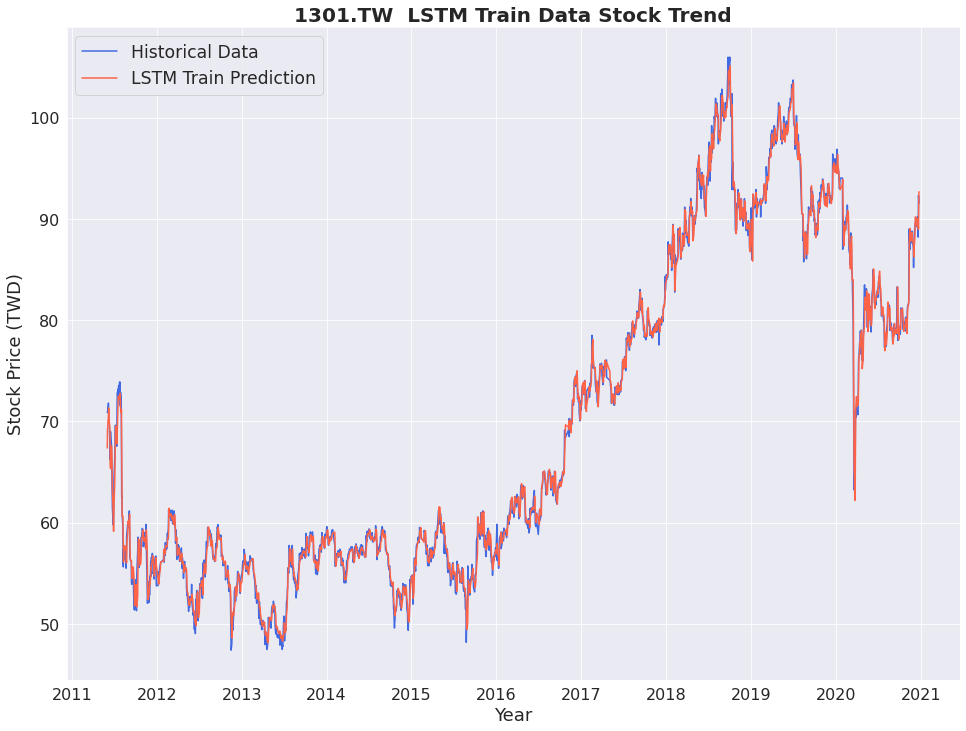

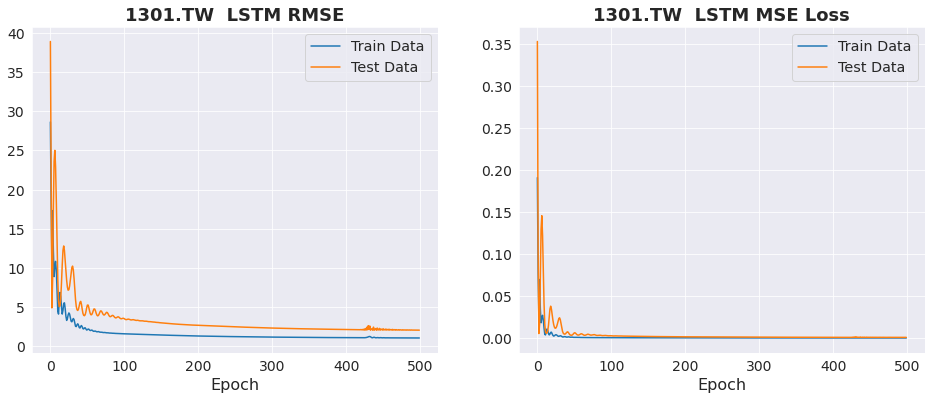

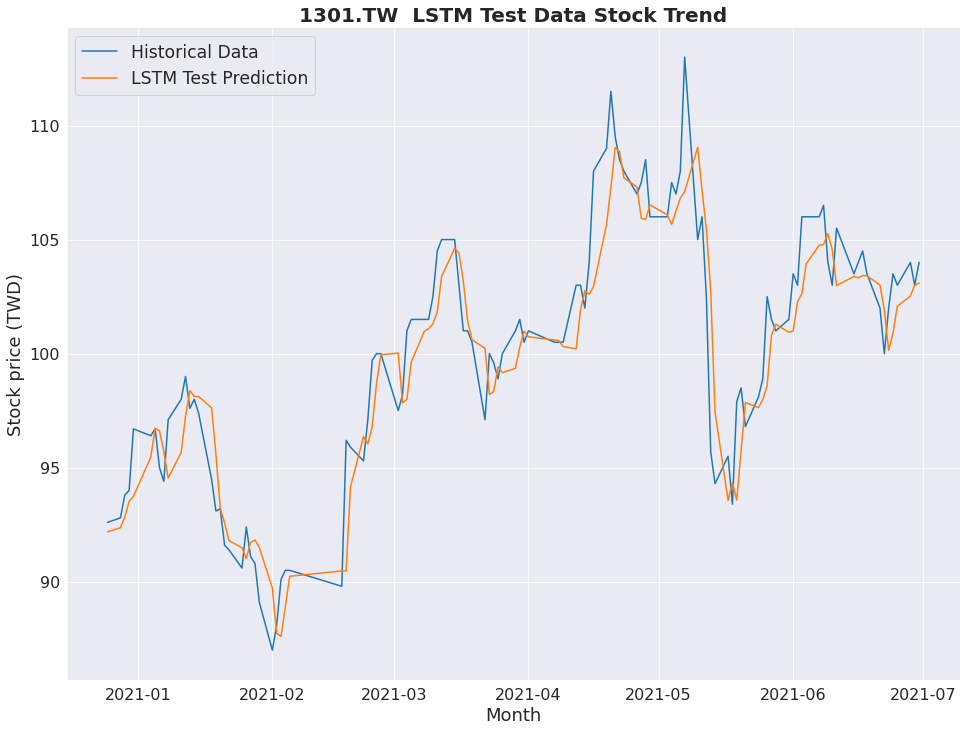

In [ ]:
#for name in names[:30]:
for name in names:
    
    # 參數設定
    ID = name 
    lookback = 10
    test_set_size = 120
    epochs = 500

    # 選取想要的股票
    df, alldate = stock(ID)

    # 保留日期資訊
    alldatelist = list(alldate)
    train_date_list = alldatelist[lookback:-test_set_size]
    test_date_list = alldatelist[-test_set_size:]

    # LSTM
    lstmstart = time.time()
    lstmdfmseplot, lstmdfpred, lstmdfscore = Stock_predict_process(ID, epochs, model_name = 'LSTM', 
                                                                   train_date_list=train_date_list, test_date_list=test_date_list)
    lstmend = time.time()
    lstm_time.append(lstmend - lstmstart)

    # GRU
    grustart = time.time()
    grudfmseplot, grudfpred, grudfscore = Stock_predict_process(ID, epochs, model_name = 'GRU', 
                                                                train_date_list=train_date_list, test_date_list=test_date_list)
    gruend = time.time()
    gru_time.append(gruend - grustart)

    # LSTM_GRU_Data_Stock_Trend_Plot
    LSTM_GRU_Data_Stock_Trend_Plot(lstmdfpred[lstmdfpred['split']=='test'].loc[:,'historical'].values,
                                   lstmdfpred[lstmdfpred['split']=='test'].loc[:,'prediction_LSTM'].values, 
                                   grudfpred[grudfpred['split']=='test'].loc[:,'prediction_GRU'].values,
                                   test_date_list=test_date_list, ID=ID)

    # 存檔
    dfpred = pd.concat([lstmdfpred, grudfpred.loc[:,'prediction_GRU']], axis=1)
    dfmseplot = pd.concat([lstmdfmseplot, grudfmseplot], axis=1)
    dfscore = pd.merge(lstmdfscore, grudfscore, how='left', on='split')

    if os.path.exists('/content/drive/MyDrive/DataSet/LSTM_feature/researchdata') is False:
        os.makedirs('/content/drive/MyDrive/DataSet/LSTM_feature/researchdata')

    dfpred.to_csv(f'/content/drive/MyDrive/DataSet/LSTM_feature/researchdata/{ID}_Prediction_Data.csv', index=False)
    dfmseplot.to_csv(f'/content/drive/MyDrive/DataSet/LSTM_feature/researchdata/{ID}_RMSE_MSELOSS_in_Training.csv', index=False)
    dfscore.to_csv(f'/content/drive/MyDrive/DataSet/LSTM_feature/researchdata/{ID}_Metrics_and_Score_.csv', index=False)

In [ ]:
dfalltime = pd.DataFrame({'name':names[:30],
                       'lstm_time':lstm_time,
                       'gru_time':gru_time})

dfalltime.to_csv(f'data/researchdata/All_Training_Time.csv', index=False)

##### just test

In [ ]:
# load the model

# modelG = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2).to(device)
# modelG.load_state_dict(torch.load('data/model/GRU_epoch500.pth')) 

# y_test_pred = modelG(x_test)
# y_test_predG = scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())

# y_test_predG
# all_y_test_pred[-1]